# Multivariate Time Series Forecasting (using LSTM)

__Problem:__ Using historical weather data, predict the next hour's temperature from the previous 24 hours' climate and temperature readings. The data contain 14 quantitative variables and 1 String timestamp. We will be primarily using Long-Short-Term Memory neurons for this forecasting problem. We will also experiment with multiple dense layers, as is somewhat standard fare in the literature.

__Variables:__

1. __Date Time__
2. __Atmospheric Pressure__ (p (mbar))
3. __Temperature in Celsius__ (T (degC))  <-- __target (what we will predict)__
4. __Potential Temperature__ (Tpot (K))
5. __Dew Point Temperature__ (Tdew (degC))
6. __Relative Humidity__ (rh (%))
7. __Saturation Water Level Pressure__ (VPmax (mbar))
8. __Actual Water Level Pressure__ (VPact (mbar))
9. __Water Level Pressure Deficit__ (VPdef (mbar))
10. __Specific Humidity__ (sh (g/kg))
11. __Water Vapor Concentration__ (H2OC (mmol/mol))
12. __Air Density__ (rho (g/m\**3))
13. __Wind Velocity__ (wv (m/s))
14. __Maximum Wind Velocity__ (max. wv (m/s))
15. __Wind Direction__ (wd (deg))

__Strategy:__ Build a base model that incorporates at least 1 LSTM layer (and possibly some dense layers). Then, if the model is learning appropriately and the error term is low enough, we can begin hyperparameter/parameter tuning.

__Scoring:__ Mean Absolute Error (MAE)

---

### Table of Contents

- Imports
- Functions for generating time-shifted input matrices
- Exploratory analysis (EDA)
- Data Prep
    - Generating input matrices
    - Normalization
    - Reshaping
- Recurrent Neural Network with LSTM Layer(s)
    - lstm_Model
    - Second Attempt

---

### Imports

In [1]:
# Cleaning
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

# Model
import tensorflow as tf
import keras
from keras.optimizers import SGD

In [2]:
# Suppresses scientific notation in numpy arrays
np.set_printoptions(suppress=True)

### Functions to Generate Time-Shifted Data

This is a Functions for time shifting rather than relying on pandas' shift() for each step in the sliding window because, out of both methods, this consumes less time. 
This is possibly because I converted the entire dataframe to numpy array and iterated over that instead of concatenating time shifted dataframe objects to build my input matrices.

In [3]:
def sliding_window(table, start, var):
    local_ = []
    global_ = []
    window = range(start, 24+start)
    for hour in window:
        if(var == 'x'): 
            element_range = range(1, len(table[hour]))
        else:
            element_range = range(2, 3)
        for i in element_range:
            local_.append(table[hour][i])
    global_.append(local_)
    return global_

In [4]:
def slide(table, start=0, var='x'):
    global_ = []
    for i in range(0, len(table)-24):
        global_.append(sliding_window(table, i, var))
    return global_

In [5]:
def validate_matrix(matrix):
    print(matrix[:3])
    print(matrix[-3:])
    print('Shape: {}'.format(matrix.shape))

In [6]:
def load_matrix(dataframe, start=0, var='x', validate=False):
    np_arr = np.array(slide(dataframe.values, start, var))
    np_arr = np.reshape(np_arr, (np_arr.shape[0], np_arr.shape[2]))
    if(validate): validate_matrix(np_arr)
    return np_arr

---

### Load Data

In [7]:
# Loading
df = pd.read_csv('./climate_hour.csv')

In [8]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [9]:
full_columns = ['Date Time', 'Atmospheric Pressure', 'Temperature',
                  'Potential Temperature', 'Dew Point Temperature', 
                  'Relative Humidity', 'Saturation Water Vapor Pressure', 
                  'Actual Water Vapor Pressure', 'Water Vapor Pressure Deficit', 
                  'Specific Humidity', 'Water Vapor Concentration', 'Air Density', 
                  'Wind Velocity', 'Maximum Wind Velocity', 'Wind Direction']

### Exploratory Data Analysis (EDA)

14 of our 15 variables are quantitative. The first variable is a String timestamp that is used to identify the day and hour at which data was collected. Since LSTM units accept only quantitative values, we will build our input matrices using the other 14 variables. But first we should take a look at their distributions.

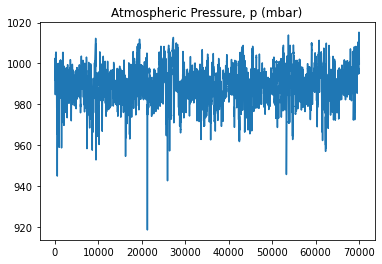

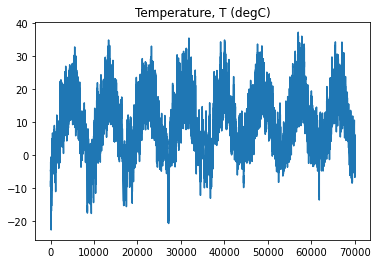

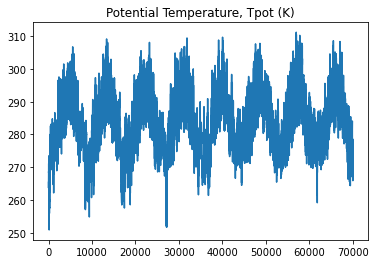

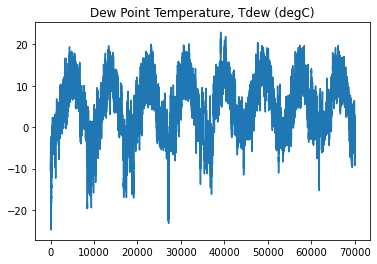

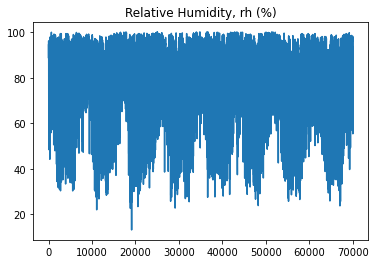

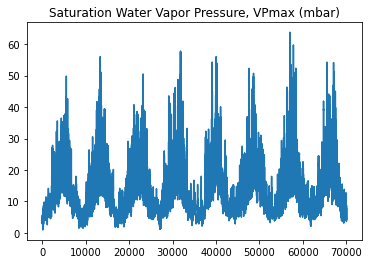

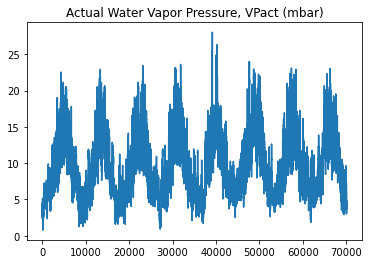

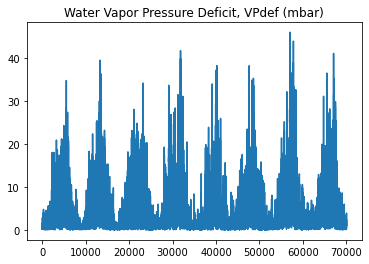

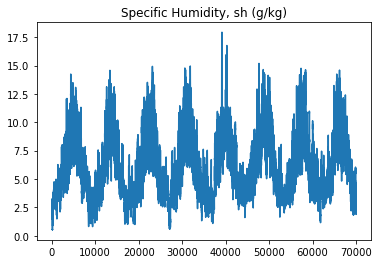

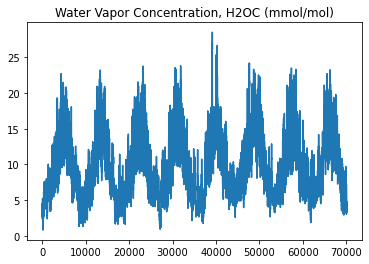

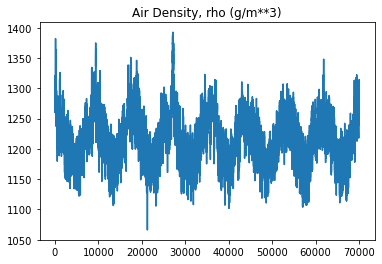

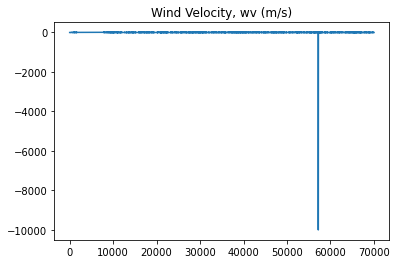

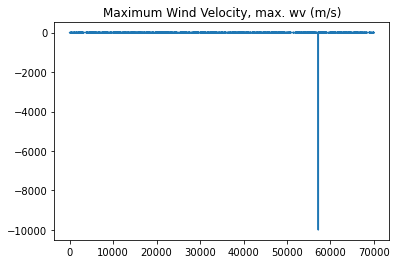

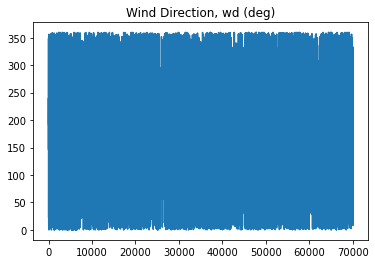

In [53]:
# Plotting each distribution
for i in range(1, df.shape[1]):
    plt.plot(df.values[:, i:i+1])
    plt.title(full_columns[i] + ', ' + df.columns[i])
    plt.show()

The 3 temperature variables, 3 vapor pressure variables, relative humidity, specific humidity, water vapor concentration, and air density are all _clearly_ patterned in such a way that (assuming the x-axis is time moving forward to the right), the data points repeat themselves in shape and magnitude over each marked time period. The 2 wind velocity variables and the wind direction are less clearly patterned. However, this is likely due to the extremely large outliers visible in the right half of the plots, which causes the scale of the entire plot to be minimized. Let's re-plot those variables so that their patterns are more clearly visible.

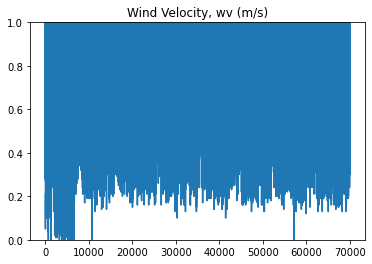

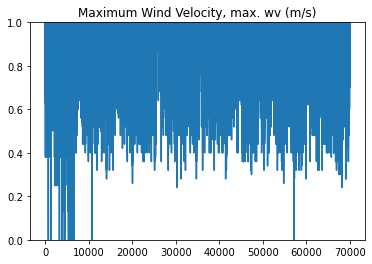

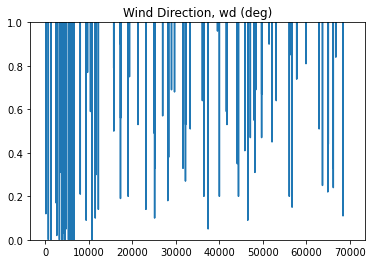

In [54]:
for i in range(12, 15):
    plt.plot(df.values[:, i:i+1], scaley=False)
    plt.title(full_columns[i] + ', ' + df.columns[i])
    plt.show()

The regular pattern, which is a hallmark of time-series data, can be seen in the above plots for wind velocity and maximum wind velocity. Notice the vertical lines punctuating the bottom edge of the shapes making up those plots. The pattern in the plot for wind direction is still not clearly visible at this scale.

The data points described in the above plots have definite, regular patterns that make the variables from which they came good candidates for time series analysis. Temporal patterns are what we would expect from weather/climate data, so it is not surprising to see patterns that can be exploited by a neural network to predict future weather measurements. You may also notice that at least two of the plots (the 2 wind velocity variables) have outliers that disrupt the even pattern of their distributions. This is part of the reason why we normalize our data, and that will be discussed further on.

The first step to generating predictions is preparing the input data to our neural network ...

---

## Data Preparation

### Input Matrices

In [55]:
# Capture the correct date range
xtrain_df = df[~df['Date Time'].str.contains('2015|2016|2017')]

In [56]:
# Apply 24-hour sliding window
X_train = load_matrix(xtrain_df, validate=True)

[[996.5   -8.05 265.38 ...   0.41   0.88 155.  ]
 [996.62  -8.88 264.54 ...   0.28   1.   148.1 ]
 [996.84  -8.81 264.59 ...   0.49   0.88 209.8 ]]
[[1004.46    1.53  274.34 ...    0.68    1.68  119.3 ]
 [1004.23    1.46  274.29 ...    0.67    1.56  145.3 ]
 [1004.4     1.47  274.28 ...    0.71    1.8   129.6 ]]
Shape: (52542, 336)


In [57]:
# Capture the correct date range
xtest_df = df[df['Date Time'].str.contains('31.12.2014|2015|2016|01.01.2017 00:00:00')]

In [58]:
# Apply 24-hour sliding window
X_test = load_matrix(xtest_df, validate=True)

[[1004.6     1.53  274.33 ...    0.35    0.86  140.8 ]
 [1004.32    1.43  274.25 ...    0.41    0.92  273.8 ]
 [1004.26    1.59  274.41 ...    0.43    0.88  119.1 ]]
[[1008.93   -2.63  269.84 ...    0.61    1.48  207.5 ]
 [1008.82   -2.98  269.5  ...    0.38    0.72    8.15]
 [1008.67   -4.09  268.41 ...    0.89    1.3   223.7 ]]
Shape: (17471, 336)


In [59]:
# Capture the partially correct date range
ytrain_df = df[~df['Date Time'].str.contains('2015|2016|2017')]

# Drop January 2009 to correct the date range
ytrain_df = ytrain_df.drop(range(0,24), axis=0) # drop January 2009

# Apply padding so window slides over final 23 hours without indexing out of bounds
bottom_padding = df[df['Date Time'].str.contains('31.12.2014')]
padded_ytrain = pd.concat([ytrain_df, bottom_padding], axis=0, sort=None)

2 different methods to generate class labels for this analysis are used:

1. Apply the same sliding window that was used on the sets of predictors in the previous step. This yields a matrix with the same number of columns as features used for the set of predictors. This is not the suggested method from the instructions. But this is what we used to build the model, which incidentally had a similar mean absolute error, training accuracy and test accuracy to the second method of generating class labels.

2. Generate a matrix in which each row contains 1 class label for each record, with the number of columns for this matrix being 1 since we have a single target variable, T (degC). This is the suggested method from the instructions.

Both methods are written out below, and at each step are clearly marked.

In [60]:
# Method 1: Apply sliding window
y_train = load_matrix(padded_ytrain, var='y', validate=True)

[[-4.44 -4.29 -4.45 -4.58 -4.96 -4.43 -4.28 -4.33 -4.13 -3.93 -3.62 -3.12
  -2.53 -2.56 -2.12 -2.76 -2.88 -3.07 -3.34 -3.3  -3.49 -4.02 -4.38 -4.71]
 [-4.29 -4.45 -4.58 -4.96 -4.43 -4.28 -4.33 -4.13 -3.93 -3.62 -3.12 -2.53
  -2.56 -2.12 -2.76 -2.88 -3.07 -3.34 -3.3  -3.49 -4.02 -4.38 -4.71 -5.28]
 [-4.45 -4.58 -4.96 -4.43 -4.28 -4.33 -4.13 -3.93 -3.62 -3.12 -2.53 -2.56
  -2.12 -2.76 -2.88 -3.07 -3.34 -3.3  -3.49 -4.02 -4.38 -4.71 -5.28 -6.23]]
[[1.96 1.94 2.18 1.53 1.43 1.59 1.35 1.39 1.18 1.04 0.78 0.66 1.06 1.89
  2.63 2.96 2.73 2.34 2.19 2.08 2.32 2.44 2.27 2.14]
 [1.94 2.18 1.53 1.43 1.59 1.35 1.39 1.18 1.04 0.78 0.66 1.06 1.89 2.63
  2.96 2.73 2.34 2.19 2.08 2.32 2.44 2.27 2.14 1.96]
 [2.18 1.53 1.43 1.59 1.35 1.39 1.18 1.04 0.78 0.66 1.06 1.89 2.63 2.96
  2.73 2.34 2.19 2.08 2.32 2.44 2.27 2.14 1.96 1.94]]
Shape: (52542, 24)


In [61]:
# Method 2
# Capture target feature
y_train_ = ytrain_df.iloc[:, 2:3]

# Flatten the target array
y_train_ = np.array(np.ravel(y_train_))

# Reshape target array to 2D
y_train_ = y_train_.reshape((y_train_.shape[0], 1))

# Print first 3 labels, last 3 labels, and array dimensions
validate_matrix(y_train_)

[[-4.44]
 [-4.29]
 [-4.45]]
[[1.96]
 [1.94]
 [2.18]]
Shape: (52542, 1)


In [62]:
# Capture correct date range
ytest_df = df[df['Date Time'].str.contains('2015|2016|01.01.2017 00:00:00')]

# Pad with last 23 hours so window slides over bottom edge of date range without indexing out of bounds
ytest_padded = pd.concat([ytest_df, df.iloc[-24:, :]], axis=0, sort=None)

In [63]:
# Method 1: Apply sliding window
y_test = load_matrix(ytest_padded, var='y', validate=True)

[[2.06 2.22 2.04 1.79 2.12 2.46 1.93 1.79 1.75 1.45 1.49 2.48 4.76 6.3
  6.12 5.25 4.   2.91 2.41 2.37 2.46 1.85 1.76 1.55]
 [2.22 2.04 1.79 2.12 2.46 1.93 1.79 1.75 1.45 1.49 2.48 4.76 6.3  6.12
  5.25 4.   2.91 2.41 2.37 2.46 1.85 1.76 1.55 1.77]
 [2.04 1.79 2.12 2.46 1.93 1.79 1.75 1.45 1.49 2.48 4.76 6.3  6.12 5.25
  4.   2.91 2.41 2.37 2.46 1.85 1.76 1.55 1.77 1.7 ]]
[[-2.59 -3.76 -4.82 -4.3  -5.08 -4.96 -4.15 -5.22 -5.27 -6.09 -6.8  -6.36
  -5.24 -3.76 -1.19  1.64  3.97  5.09  2.87  1.41 -0.08 -1.03 -1.52 -3.09]
 [-3.76 -4.82 -4.3  -5.08 -4.96 -4.15 -5.22 -5.27 -6.09 -6.8  -6.36 -5.24
  -3.76 -1.19  1.64  3.97  5.09  2.87  1.41 -0.08 -1.03 -1.52 -3.09 -2.59]
 [-4.82 -4.3  -5.08 -4.96 -4.15 -5.22 -5.27 -6.09 -6.8  -6.36 -5.24 -3.76
  -1.19  1.64  3.97  5.09  2.87  1.41 -0.08 -1.03 -1.52 -3.09 -2.59 -3.76]]
Shape: (17471, 24)


In [64]:
# Method 2
# Capture target feature
y_test_ = ytest_df.iloc[:, 2:3]

# Flatten the target array
y_test_ = np.array(np.ravel(y_test_))

# Reshape target array to 2D
y_test_ = y_test_.reshape((y_test_.shape[0], 1))

# Print first 3 labels, last 3 labels, and array dimensions
validate_matrix(y_test_)

[[2.06]
 [2.22]
 [2.04]]
[[-2.59]
 [-3.76]
 [-4.82]]
Shape: (17471, 1)


Matrices is created now , we can normalize our data. 
Why do we want to normalize the data?
Because when training neural networks, or many machine learning algorithms, large outliers and influential points can slow down learning and prevent the algorithm from effectively learning in what way each variable relates to another in determining the value of the target.
We normalize the data, commonly by scaling their values between 0 and 1, to prevent especially large data points from having an outsized influence on that learning process.

### Min-Max Normalization

Using Method 1 Labels ...

In [65]:
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(0,1))

# Fit + Transform distributions
X_train_sc = scaler.fit_transform(X_train, y_train)
X_test_sc = scaler.fit_transform(X_test, y_test)
y_train_sc_1 = scaler.fit_transform(y_train)
y_test_sc_1 = scaler.fit_transform(y_test)

Using Method 2 Labels ...

In [66]:
y_train_2 = scaler.fit_transform(y_train_)
y_test_2 = scaler.fit_transform(y_test_)

---

Now we need to reshape our predictor matrices from 2D to 3D so that they will be accepted by the LSTM layer as input

### Reshaping 2D Matrices to 3D (for LSTM)

In [67]:
timesteps = 24 #the size of our sliding window
data_dim = 14 #the number of features we are using

In [68]:
X_train = np.reshape(X_train_sc, (X_train_sc.shape[0], timesteps, data_dim))
X_test = np.reshape(X_test_sc, (X_test_sc.shape[0], timesteps, data_dim))

# Method 1 labels
y_train_1 = np.reshape(y_train_sc_1, (y_train_sc_1.shape[0], timesteps, 1))
y_test_1 = np.reshape(y_test_sc_1, (y_test_sc_1.shape[0], timesteps, 1))

# Method 2 labels can't be reshaped sensibly, so must be entered into the network in their current shape (n, 1) where n is the total number of rows

Validating our set shapes ...

In [69]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

print('\nClass labels generated using method 1:')
print('y_train_1 shape: {}'.format(y_train_1.shape))
print('y_test_1 shape: {}'.format(y_test_1.shape))

print('\nClass labels generated using method 2:')
print('y_train_2 shape: {}'.format(y_train_2.shape))
print('y_test_2 shape: {}'.format(y_test_2.shape))

X_train shape: (52542, 24, 14)
X_test shape: (17471, 24, 14)

Class labels generated using method 1:
y_train_1 shape: (52542, 24, 1)
y_test_1 shape: (17471, 24, 1)

Class labels generated using method 2:
y_train_2 shape: (52542, 1)
y_test_2 shape: (17471, 1)


We are finally ready to build our models. 


In [70]:
histories = [] # stores the Keras History objects, from which graphs were plotted

### RNN using LSTM

In [71]:
lstm_model = keras.Sequential([
    keras.layers.LSTM(16, input_shape=(timesteps, data_dim), return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.Dense(1)
])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 16)            1984      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 16)            2112      
_________________________________________________________________
dense_3 (Dense)              (None, 24, 1)             17        
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
_________________________________________________________________


In [72]:
lstm_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [73]:
history = lstm_model.fit(X_train, y_train_1, batch_size=75, epochs=10, validation_data=(X_test, y_test_1))
lstm_model.save('lstm_model.h5')
histories.append(history)

Epoch 1/10
701/701 [==============================] - 11s 12ms/step - loss: 0.0289 - accuracy: 3.2057e-05 - val_loss: 0.0054 - val_accuracy: 1.1448e-04
Epoch 2/10
701/701 [==============================] - 8s 11ms/step - loss: 0.0048 - accuracy: 4.0122e-05 - val_loss: 0.0064 - val_accuracy: 1.1448e-04
Epoch 3/10
701/701 [==============================] - 8s 11ms/step - loss: 0.0040 - accuracy: 3.3262e-05 - val_loss: 0.0075 - val_accuracy: 1.1448e-04
Epoch 4/10
701/701 [==============================] - 8s 11ms/step - loss: 0.0038 - accuracy: 3.8607e-05 - val_loss: 0.0057 - val_accuracy: 1.1448e-04
Epoch 5/10
701/701 [==============================] - 8s 11ms/step - loss: 0.0036 - accuracy: 4.3408e-05 - val_loss: 0.0052 - val_accuracy: 1.1448e-04
Epoch 6/10
701/701 [==============================] - 8s 12ms/step - loss: 0.0035 - accuracy: 3.3088e-05 - val_loss: 0.0068 - val_accuracy: 1.1448e-04
Epoch 7/10
701/701 [==============================] - 8s 12ms/step - loss: 0.0034 - accuracy:

### Model Prediction

In [74]:
predictions = lstm_model.predict(X_test)

In [75]:
# Reshape predictions and y_test, since using Method 1 they are both 3D
pred_2d = np.reshape(predictions, (predictions.shape[0], predictions.shape[1]))
y_2d = np.reshape(y_test_1, (y_test_1.shape[0], y_test_1.shape[1]))

In [76]:
# Denormalize predictions, true class labels using inverse transformation
pred_denorm = scaler.inverse_transform(pred_2d)
y_denorm = scaler.inverse_transform(y_2d)

In [77]:
lstm_mae = mae(y_denorm, pred_denorm)
print('lstm_model\nMean Absolute Error (MAE) = {:.8f}'.format(lstm_mae))

lstm_model
Mean Absolute Error (MAE) = 3.92567264


__Discussion of lstm_model__

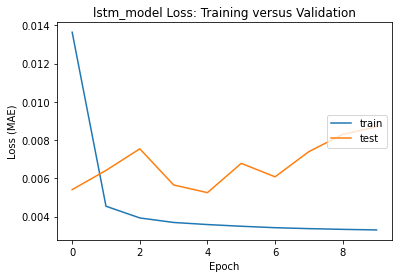

In [78]:
# Plot history for losses (training versus validation)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model Loss: Training versus Validation')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Here we see that the loss has a net negative trend across both training and testing sets. For the testing set, the loss briefly increases, then dips downward for a global minimum at the final epoch. The training loss has a more dramatic downward trajectory, but shows the same phenomenon.

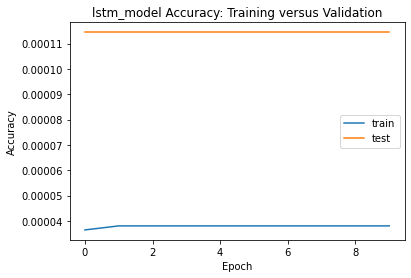

In [79]:
# Plot history for accuracies (training versus validation)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('lstm_model Accuracy: Training versus Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

The above plot shows that training accuracy and validation accuracy do not increase over the course of training. This is clearly an indication that model is not learning.

The training accuracy and validation accuracy did not increase and remained flat no matter how many epochs the model trained for or what hyperparameters were tweaked. Tried tweaking the optimization method from 'adam' to a custom optimization object using stochastic gradient descent with various values for learning rate, momentum and decay.


#### Attempt Number 2

In [80]:
attempt_2 = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(timesteps, data_dim), return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(64),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
attempt_2.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 128)           73216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 124,737
Trainable params: 124,737
Non-trainable params: 0
________________________________________________

In [81]:
attempt_2.compile(optimizer='sgd', loss='mae', metrics=['accuracy'])

In [82]:
history_2 = attempt_2.fit(X_train, y_train_2, batch_size=450, epochs=10, validation_data=(X_test, y_test_2), shuffle=False)
attempt_2.save('attempt_2.h5')
histories.append(history_2)

Epoch 1/10
117/117 [==============================] - 18s 138ms/step - loss: 0.1577 - accuracy: 1.1058e-04 - val_loss: 0.0915 - val_accuracy: 1.1448e-04
Epoch 2/10
117/117 [==============================] - 16s 137ms/step - loss: 0.0825 - accuracy: 1.1058e-04 - val_loss: 0.0722 - val_accuracy: 1.1448e-04
Epoch 3/10
117/117 [==============================] - 16s 137ms/step - loss: 0.0693 - accuracy: 1.1058e-04 - val_loss: 0.0712 - val_accuracy: 1.1448e-04
Epoch 4/10
117/117 [==============================] - 16s 137ms/step - loss: 0.0631 - accuracy: 1.1058e-04 - val_loss: 0.0715 - val_accuracy: 1.1448e-04
Epoch 5/10
117/117 [==============================] - 16s 136ms/step - loss: 0.0600 - accuracy: 1.1058e-04 - val_loss: 0.0739 - val_accuracy: 1.1448e-04
Epoch 6/10
117/117 [==============================] - 16s 136ms/step - loss: 0.0575 - accuracy: 1.1058e-04 - val_loss: 0.0692 - val_accuracy: 1.1448e-04
Epoch 7/10
117/117 [==============================] - 16s 136ms/step - loss: 0.055

__Second Attempt Model Predictions__

In [83]:
pred = attempt_2.predict(X_test)

Since our class labels were 2D, so are our predictions and there is no need for reshaping these vectors. But we do need to denormalize still...

In [84]:
# Inverse transform scaling
pred_denorm = scaler.inverse_transform(pred)
y_test_denorm = scaler.inverse_transform(y_test_2)

In [85]:
attempt_2_mae = mae(y_test_denorm, pred_denorm)
print('Attempt 2 Model:\nMean Absolute Error (MAE) = {:.8f}'.format(attempt_2_mae))

Attempt 2 Model:
Mean Absolute Error (MAE) = 3.49532501


__Discussion of Second Attempt Model__

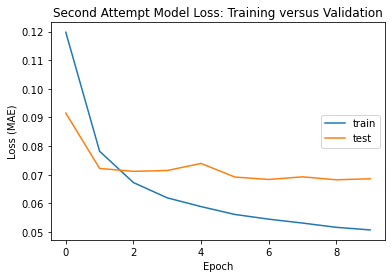

In [86]:
# Plot history for losses (training versus validation)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Second Attempt Model Loss: Training versus Validation')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

The mean absolute error for predictions on the final epoch was lower on this,  best second attempt model, than the lstm_model(first model) .
The difference in errors is not very much, however, and could easily be due to random weight initializations. When comparing the trend lines between this model and the lstm_model, it seems that the validation loss trends upward (net increase) in the lstm_model while this model's test loss trends downward ever so slightly. The difference, however, is not large enough to be signficant and is somewhat belied by the fact that both models' training losses were net decreasing.

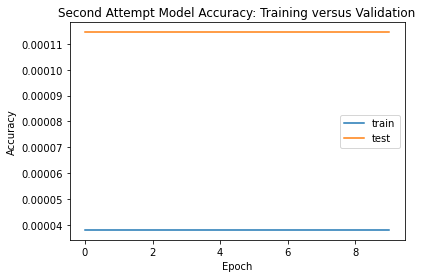

In [87]:
# Plot history for accuracies (training versus validation)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Second Attempt Model Accuracy: Training versus Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Recurrent neural networks are the best known for time-series predictions as they can process sequence data and also they can be integrated with convolutional neural networks (CNN) for processing sophisticated hybrid models,

but also they do take up a lot of memory for processing. 


I would like to suggest some of the ways to you can follow to increase the accuracy of the model:
1. Increase or decrease the number of epochs. Try with a different number of epochs like 100, 200, 300… and so on
2. One of the best ways is to use a large dataset and train the model, but this might take a longer time. You can use GPUs with    Keras by installing CUDA. Refer to this article for more information.
3. Add more LSTM layers to the RNN.